### Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

### Reflect tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import os

In [3]:
# Create database connection
engine = create_engine(os.path.join("sqlite:///","Resources","hawaii.sqlite"))

In [4]:
# Declare a base and reflect an existing database into a new model
Base = automap_base()
# Use the base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

### __Percipitation Analysis__

In [8]:
# Inspect the measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Design a query to retrieve the last 12 months of precipitation data

# find last data point for date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores & save query results as a Pandas DataFrame
last_12_mos = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
# print(last_12_mos)

# Set the index to the date column & sort the dataframe by date
last_12_mos = last_12_mos.set_index('date')
last_12_mos = last_12_mos.sort_values('date')
last_12_mos.head()

('2017-08-23',)
2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [10]:
# explore dataframe and database for null values
last_12_mos.isnull().any()
last_12_mos_explore = pd.read_sql(session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
last_12_mos_explore.loc[last_12_mos_explore.isnull().any(axis=1)]

# the null values for prcp appear to be for stations that reported a tobs on that date but not a prcp
# based on this, we can conclude that the null values for prcp in the 'last_12_mos' dataframe can be dropped for the precipitation analysis 
last_12_mos = last_12_mos.dropna(how='any')
last_12_mos = last_12_mos.rename(columns={'prcp':'Precipitation'})
last_12_mos.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


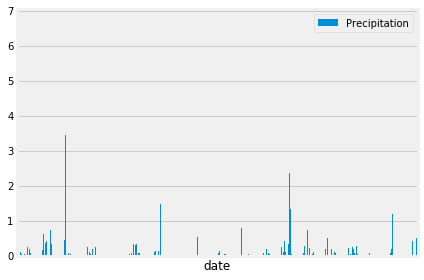

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12_mos.plot(kind="bar")
plt.xticks([])
plt.tight_layout()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_mos.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### __Station Analysis__

In [13]:
# Inspect the station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f'There are {station_count} stations in this dataset.')

There are 9 stations in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_frequency = session.query(Measurement.station, 
                                  func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(station_frequency)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [44]:
# Join measurement and station table to get the names of each station
join=session.query(Measurement.station, Station.name, func.count(Measurement.station)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
join

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [45]:
# Which station has the highest number of observations?
highest_obs = station_frequency[0][0]
highest_obs_name =  join[0][1]
print(f'The station with the highest number of observations is {highest_obs}, {highest_obs_name}.')

The station with the highest number of observations is USC00519281, WAIHEE 837.5, HI US.


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} lowest recorded temperature: {low_temp}.')

high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} highest recorded temperature: {high_temp}.')

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} average temperature: {avg_temp}.')

Station USC00519281 lowest recorded temperature: [(54.0,)].
Station USC00519281 highest recorded temperature: [(85.0,)].
Station USC00519281 average temperature: [(71.66378066378067,)].


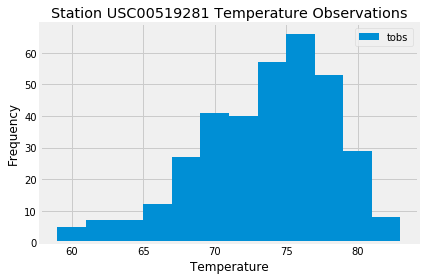

In [42]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Station with the highest number of temp obs during 12 month frame
# top_tobs = session.query(Measurement.station, 
#                                   func.count(Measurement.tobs)).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

tobs_12_mos = pd.read_sql(session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == highest_obs).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
tobs_12_mos.head()
tobs_12_mos.hist(bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f'Station {highest_obs} Temperature Observations')
plt.legend()
plt.tight_layout()